# Assignment 2: Random walk Metropolis(-Hastings) Method
## a. Apply the random walk Metropolis(-Hastings) method
We are using the $\tilde{\theta} \sim N(\theta_{i-1}, 0.05^2)$, as our candidate distribution. We are simulating $n = 11000$, with a burn-in of 1000. 

Since I just installed the new (allegedly faster) Python version, I need to install numpy, matplotlib, pip and scipy.

In [1]:
!python3.11 -m pip install --upgrade numpy scipy matplotlib pip statsmodels tqdm ipywidgets

Then we import these libraries:

In [2]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import statsmodels.api as sm

Then we run the Metropolis-Hastings random walk, from the pseudocode described in the slides. We estimate the mean, and show the histogram.

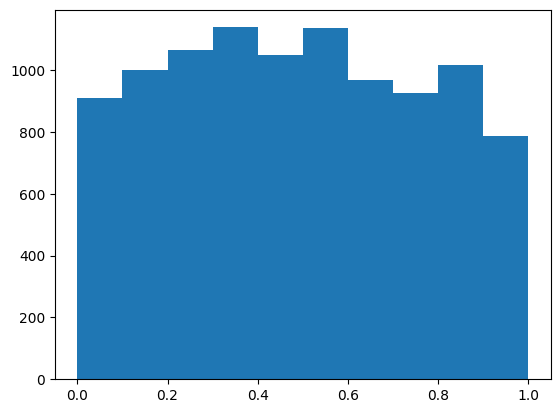

'Mean estimation = 0.48916101211731877'

In [3]:
theta_0 = 0.5
n_draws = 11000
burn_in = 1000
theta = np.zeros(n_draws)
theta[0] = theta_0
sigma = 0.05
draws = 0

P = lambda tilde_hat: 1.0 if 0.0 <= tilde_hat <= 1.0 else 0

def get_draw(i):
    theta_tilde = sts.norm.rvs(loc=theta[i-1], scale=sigma)
    alpha = min(P(theta_tilde)/P(theta[i-1]), 1)
    U = sts.uniform.rvs()
    global draws
    
    if (i > burn_in):
        draws += 1
    
    if U <= alpha:
        return theta_tilde
    
    return get_draw(i)

for i in range(1, n_draws):
    theta[i] = get_draw(i)

plt.hist(theta[burn_in:])
plt.show()
f"Mean estimation = {theta[burn_in:].mean()}"

From our simulation we can generate the traceplot

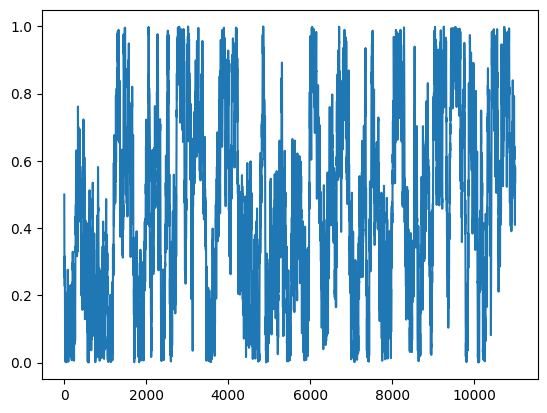

In [4]:
plt.plot(np.arange(n_draws), theta)
plt.show()

We can compute the serial correlation:

In [5]:
np.corrcoef(theta[burn_in:-1], theta[burn_in+1:])[0,1]

0.984307576606194

Finally we compute the acceptence $\alpha$.

In [6]:
nbm_of_draws = (n_draws - burn_in)
nbm_of_draws/draws

0.962278675904542

## b. Daily returns
We are calculating the daily returns from Apple. First we import pandas, and read the data file.

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv("AAPL.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-11-21,44.932499,45.067501,44.137501,44.195000,42.655937,124496800
1,2018-11-23,43.735001,44.150002,43.025002,43.072498,41.572525,94496000
2,2018-11-26,43.560001,43.737499,42.564999,43.654999,42.134747,179994000
3,2018-11-27,42.877499,43.692501,42.720001,43.560001,42.043056,165549600
4,2018-11-28,44.182499,45.322498,43.732498,45.235001,43.659718,184250000
...,...,...,...,...,...,...,...
1001,2022-11-14,148.970001,150.279999,147.429993,148.279999,148.279999,73374100
1002,2022-11-15,152.220001,153.589996,148.559998,150.039993,150.039993,89868300
1003,2022-11-16,149.130005,149.869995,147.289993,148.789993,148.789993,64218300
1004,2022-11-17,146.429993,151.479996,146.149994,150.720001,150.720001,80389400


In [9]:
df_close = np.array(df["Close"])
df_close

array([ 44.195   ,  43.072498,  43.654999, ..., 148.789993, 150.720001,
       151.289993])

In [10]:
daily_returns = 100 * (np.log(df_close[1:]) - np.log(df_close[:-1]))
daily_returns


array([-2.57269645,  1.34331044, -0.21784793, ..., -0.83660098,
        1.28879487,  0.3774661 ])

## c. ARCH(1)
Now we are using the ARCH(1) model.

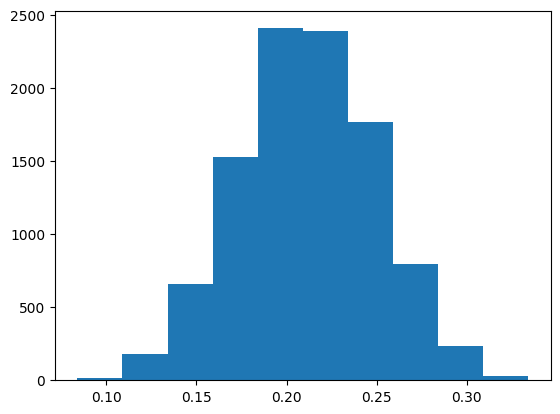

'Mean estimation = 0.211462461951129, std. est. 0.037883240473827136'

In [11]:
alpha_1_0 = 0.2
n_draws = 11000
alpha_1 = np.zeros(n_draws)
alpha_1[0] = alpha_1_0
s_squared = np.var(daily_returns)
draws = 0

def p(y, _alpha_1):
    sum = 0
    for i in range(1, len(y)):
        sum += -0.5*np.log(2 * np.pi * (s_squared * (1 - _alpha_1) + _alpha_1 * y[i-1] ** 2)) - (y[i]**2)/(2 * (s_squared * (1 - _alpha_1) + _alpha_1 * y[i-1] ** 2))
        # sum += -0.5 * np.log(s_squared * (1 - _alpha_1) + _alpha_1*(y[i-1]**2) - (y[i]**2)/(2 * (s_squared * (1 -  _alpha_1) + _alpha_1 * y[i] ** 2)))
    return sum

def calculate_acceptence_prob(alpha_tilde, alpha_prev):
    if 0.0 < alpha_tilde <= 1.0:
        return min(np.exp(p(daily_returns, alpha_tilde) - p(daily_returns, alpha_prev)), 1)
    
    return 0


def draw(i):
    alpha_1_tilde = sts.norm.rvs(loc=alpha_1[i-1], scale=0.03)
    acceptence_prob = calculate_acceptence_prob(alpha_1_tilde, alpha_1[i-1])
    U = sts.uniform.rvs()
    global draws

    if (i > burn_in):
        draws += 1
    
    if U <= acceptence_prob:
        return alpha_1_tilde

    return draw(i)


for i in range(1, n_draws):
    alpha_1[i] = draw(i)

plt.hist(alpha_1[burn_in:])
plt.show()
f"Mean estimation = {alpha_1[burn_in:].mean()}, std. est. {alpha_1[burn_in:].std()}"

We can get the following trace

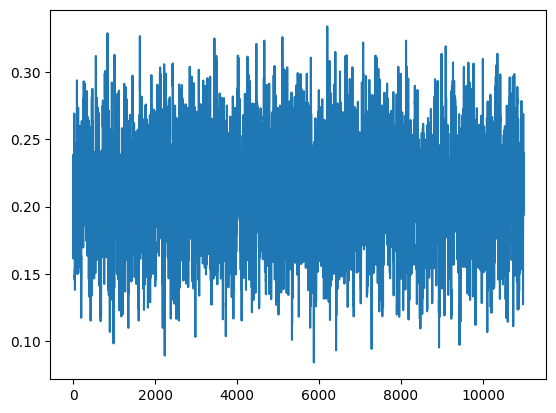

In [12]:
plt.plot(np.arange(n_draws), alpha_1)
plt.show()

And get the following serial correlation

In [13]:
np.corrcoef(alpha_1[burn_in:-1], alpha_1[burn_in+1:])[0,1]

0.7730080025236364

And finally we can get the acceptence rate $\alpha$

In [14]:
nbm_of_draws = (n_draws - burn_in)
nbm_of_draws/draws

0.7759757895553658